# Machine learning dismantling and early-warning signals of disintegration in complex systems
[Paper Link](https://https://www.nature.com/articles/s41467-021-25485-8)


Model parameters

Convolutional-style layers: Graph Attention Network layers.

Number of layers: from 1 to 4;

Output channels for each layer: 5, 10, 20, 30, 40, or 50, sometimes with a decreasing value between consecutive layers;

Multi-head attentions: 1, 5, 10, 15, 20, or 30 concatenated heads;

Dropout probability: fixed to 0.3;

Leaky ReLU angle of the negative slope: fixed to 0.2;

Each layer learns an additive bias;

Each layer is coupled with a linear layer with the same number of input and output channels;

Activation function: Exponential Linear Unit (ELU). The input at each convolutional layer is the sum between the output of the GAT and the linear layers;

Regressor: multilayer perceptron

Number of layers: from 1 to 4;

Number of neurons per layer: 20, 30, 40, 50, or 100, sometimes with a decreasing value between consecutive layers.

Learning rate: fixed to 10−5;

Epochs: we train each model for 50 epochs;

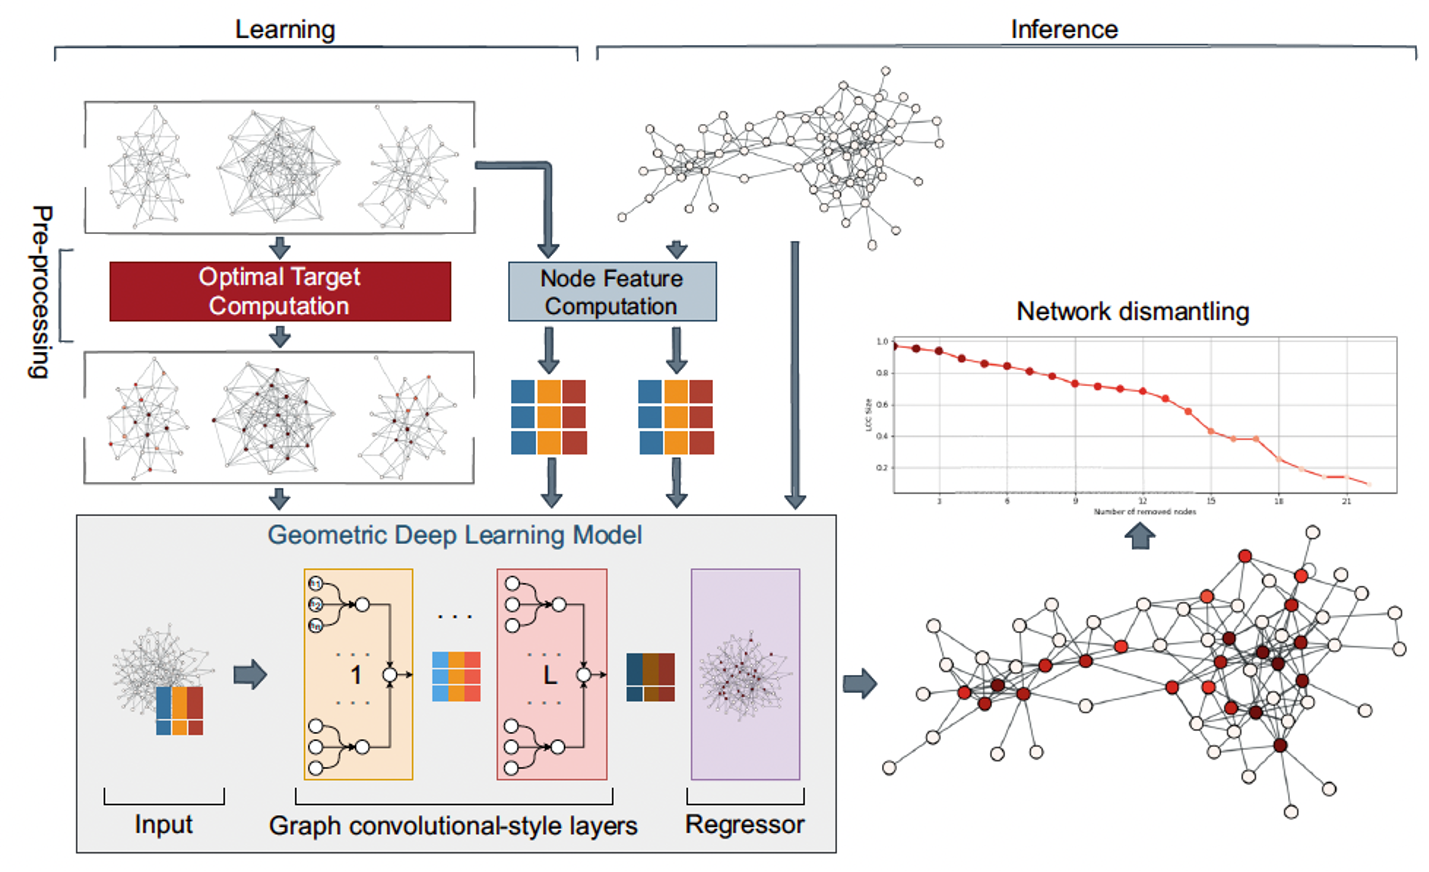

In [1]:
!mkdir Data 
!mkdir Results
!mkdir All
python -u ./network_dismantling/machine_learning/pytorch/dataset_generator.py -d ./dataset/synth_train_NEW/dataset/ -o ./TrainingData_Pairwise -j 4 -F "*"


# Dataset

In [1]:
from pathlib2 import Path
from glob import glob
from graph_tool.all import *

def load_graph(file, fmt="auto", ignore_vp=None, ignore_ep=None,
               ignore_gp=None, directed=True, **kwargs):
    unicode = "UTF-8"
    import warnings


    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        from graph_tool import load_graph

    if fmt == 'auto' and isinstance(file, (str, unicode)) and \
            Path(file).suffix[1:] in ["csv", "edgelist", "edge", "edges", "el"]:
        # g = load_edgelist(file, directed=directed)
        delimiter = "," if Path(file).suffix == ".csv" else " "
        g = load_graph_from_csv(file,
                                directed=directed,
                                eprop_types=kwargs.get("eprop_types", None),
                                eprop_names=kwargs.get("eprop_names", None),
                                string_vals=kwargs.get("string_vals", False),
                                hashed=kwargs.get("hashed", False),
                                skip_first=kwargs.get("skip_first", False),
                                ecols=kwargs.get("ecols", (0, 1)),
                                csv_options=kwargs.get("csv_options", {
                                    "delimiter": delimiter,
                                    "quotechar": '"'
                                }),
                                )
    else:
        g = load_graph(file, fmt=fmt, ignore_vp=ignore_vp, ignore_ep=ignore_ep, ignore_gp=ignore_gp, **kwargs)

    return g
def storage_provider(location, filter="*", callback=None):
    networks = list()
    for file in sorted(glob(str(location +"/"+ (filter + ".graphml")))):
        filename = Path(file).stem
        network = load_graph(file)
        assert not network.is_directed()

        network.graph_properties["filename"] = network.new_graph_property("string", filename)

        if callback:
            callback(filename, network)

        networks.append((filename, network))
    return networks


In [3]:
from os import listdir
from os.path import isfile, join
import networkx as nx

def input_graph(graph_path):
    fh = open(graph_path, "rb")
    GRAPH = nx.read_edgelist(graph_path)
    fh.close()
    nodes = GRAPH.nodes()
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def convert_GraphML(mypath,newpath):
    files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for f in files:
        G,_ =input_graph(mypath+f)
        f = f.replace(".txt","")
        nx.write_graphml(G, newpath+f+".graphml",named_key_ids=True)
convert_GraphML("./All/","./Test_Data/")

In [15]:
from os import listdir, system
from os.path import isfile, join

done_path = "./TrainingData_Pairwise"
data_path = "./dataset/synth_train_NEW/dataset/"
done_files = [f for f in listdir(done_path) if isfile(join(done_path, f))]
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]
new = list(set(data_files).difference(done_files))
for n in new:
    original = data_path+n
    destination = "./ToCreate/"+n
    command = 'cp '+ original+" "+ destination
    #system('cp source.txt destination.txt')  
    system(command)  

## Features

In [2]:
from pandas.core.ops.array_ops import get_array_op
from collections import defaultdict
from itertools import combinations, chain
import networkx as nx
from collections import Counter
import numpy as np
from graph_tool import *
import pandas as pd

# Chi-squared ([o]bserved, [e]xpected)
def chi(o, e):
    if e == 0:
        return 0
    return (o - e) ** 2 / e
def sum_degree_j2(x,g): 
    sum = np.sum(g.get_total_degrees(g.get_all_neighbors(x))**2)
    return sum

def training_data_extractor(g, threshold=None, output_file=None, target_property_name="target", vertices=None,
                            compute_targets=True, features=None, logger=None, k_range=None):
    
    #features_list = ["num_vertices", "num_edges", "degree", "clustering_coefficient", "eigenvectors", "chi_degree",
     #       "chi_lcc", "pagerank_out", "betweenness_centrality", "kcore","resilience_centrality"]
    features_list = ["degree", "clustering_coefficient", "chi_degree", "kcore"]
    if logger is None:
        def logger(record):
            pass
    # def logger(record):
    #     log_queue.put(record)
    #     pass
    
    
    
    if features is None:
            features_dict = defaultdict(lambda: True)
    else:
            features_dict = defaultdict(lambda: False, ((f, True) for f in features))
    
    if vertices is None:
        vertices = g.get_vertices()
    out_features = dict()
    
    try:
            g.vertex_properties["static_id"]
    except:
            static_id = g.new_vertex_property("int32_t")            # Double-precision floating point
            for v in g.get_vertices():
                static_id[v] = v
            g.vertex_properties["static_id"] = static_id

        


    if features_dict["degree"] or features_dict["chi_degree"]:
        logger("Computing Degree")
        degree = g.get_out_degrees(vertices)

        logger("Computing Max degree")
        max_degree = np.max(degree)

        logger("Normalizing the degree")
        degree = np.divide(degree, max_degree)

        if features_dict["degree"]:
            out_features["degree"] = degree

        if features_dict["chi_degree"]:
            logger("Computing Mean Normalized Degree")
            average_degree = np.mean(degree)

            logger("Computing Chi Degree")
            chi_degree = [chi(degree[v], average_degree) for v in vertices]

            out_features["chi_degree"] = chi_degree

    if features_dict["eigenvectors"]:
        logger("Computing Eigenvectors")
        _, eigenvectors = eigenvector(g)

        out_features["eigenvectors"] = eigenvectors
    
    if features_dict["resilience_centrality"]:
        logger("Computing Resilience Centrality")
        #A = adjacency(g, operator=True)
        c , std = vertex_average(g, "total")
        beta_eff = (c**2 + std**2)/c
        res_v = []
        N =g.num_vertices()
        for v in vertices:
            D = sum_degree_j2(v,g) 
            d = g.get_total_degrees([v])
            a = 2*D + d*(d-2*beta_eff)
            r = a / (N*(c**2 + std**2))
            res_v.append(r)
        out_features["resilience_centrality"] = res_v
    if features_dict["clustering_coefficient"] or features_dict["chi_lcc"]:

        logger("Computing LCC")
        clustering_coefficient = local_clustering(g)

        logger("Computing Mean LCC")
        avg_lcc = np.mean(clustering_coefficient.get_array())

        logger("Computing Chi LCC")
        chi_lcc = [chi(clustering_coefficient[v], avg_lcc) for v in vertices]

        if features_dict["clustering_coefficient"]:
            out_features["clustering_coefficient"] = clustering_coefficient
        if features_dict["chi_lcc"]:
            out_features["chi_lcc"] = chi_lcc

    # logger("Computing Neighbors")
    # neighbours = [g.get_out_neighbors(v) for v in vertices]
    #
    # logger("Computing Neighbors Mean Chi Degree")
    # mean_chi_degree = [np.mean([chi_degree[i] for i in x]) if len(x) > 0 else 0 for x in neighbours]
    #
    # logger("Computing Neighbors Mean Chi LCC")
    # mean_chi_lcc = [np.mean([chi_lcc[i] for i in x]) if len(x) > 0 else 0 for x in neighbours]

    if features_dict["pagerank_out"]:
        logger("Computing Pagerank")
        pagerank_out = pagerank(g)

        out_features["pagerank_out"] = pagerank_out

    if features_dict["betweenness_centrality"]:
        logger("Computing Betweenness")
        betweenness_centrality, _ = betweenness(g)

        out_features["betweenness_centrality"] = betweenness_centrality

    if features_dict["kcore"]:
        # K-core
        logger("Computing the K-core and normalising it")
        kcore = kcore_decomposition(g)

        kcore_array = kcore.get_array()
        kcore_array = np.divide(kcore_array, np.max(kcore_array))

        out_features["kcore"] = kcore_array

    logger("Adding Properties")

    if compute_targets is True:
        targets = g.new_vertex_property("float")
        g.vertex_properties[target_property_name] = targets

        logger("Computing LCC size deltas")

        best_combinations = set()
        num_vertices = g.num_vertices()

        if threshold is None:
            exit("ERROR: No threshold provided!")

        stop_condition = np.ceil(float(num_vertices * threshold))
        if k_range is None:
            k_range = range(0, num_vertices)
        for k in k_range:
            logger("Trying with {} / {} vertices long combinations".format(k, num_vertices))
            #Get Largest Connected Components
            best_score = num_vertices
            #Get pairwise connectivity
            #comp = Counter(label_components(g)[0])
            #best_score = sum([(comp[i] * (comp[i]-1))/2 for i in comp])

            # Generate all the possible combinations of length k
            for combination in combinations(g.get_vertices(), k):
                local_network = g.copy()

                local_network.remove_vertex(combination)
                #Get Largest Connected Components
                local_network_lcc_size = (np.count_nonzero(label_largest_component(local_network).get_array()))
                #Get pairwise connectivity
                #comp = Counter(label_components(local_network)[0])
                #local_network_lcc_size = sum([(comp[i] * (comp[i]-1))/2 for i in comp])
                #Get Max Connected Components
                #local_network_lcc_size =  max(label_components(g, attractors=True)[0])
                if local_network_lcc_size < best_score:
                    best_score = local_network_lcc_size
                    best_combinations = set()
                    best_combinations.add(combination)
                elif local_network_lcc_size == best_score:
                    best_combinations.add(combination)

            if best_score <= stop_condition:
                logger("Found that {} vertices break the network apart".format(k))
                break

        num_combinations = len(best_combinations)

        # Count number of occurrences:
        all_occurrences = list(chain.from_iterable(best_combinations))
        unique, counts = np.unique(all_occurrences, return_counts=True)

        if len(unique) == 0:
            # Handle networks that already satisfy the requirement
            for v in vertices:
                targets[v] = 0
        else:

            for key, value in zip(list(unique), list(counts)):
                # occurrences_count
                # TODO CHECK ME!
                targets[key] = (value / num_combinations)

    # Store the features as vertex properties
    # TODO IMPROVE ME
    for f in features_list:
        if features_dict[f] is not True:
            continue

        if f in ["num_vertices", "num_edges"]:
            continue

        property = g.new_vertex_property("float", vals=out_features[f])

        # Add vertex properties to the internal representation of the graph
        g.vertex_properties[f] = property

    # TODO Move me
    if output_file is not None:
        # # Create feature list graph property
        # g.graph_properties["features"] = g.new_graph_property("string", ','.join(
        #     f for f in features_list if features_dict[f] is True))

        # # Create feature vertex property
        # features_property = g.new_vertex_property("string")
        # for v in vertices:
        #     features_property[v] = ','.join(str(out_features[f][v]) for f in features_list if features_dict[f] is True)
        logger("Storing the graph")
        g.save(output_file, fmt='graphml')
#print(g.shape)
def logger(record):
    print(record)

In [3]:
import torch 
from torch_geometric.data import Data
def prepare_graph(network, features=None, targets=None):
    # Retrieve node features and targets
    # features_property = network.vertex_properties["features"]

    # TODO IMPROVE ME
    if features is None:
        features = all_features

    if "None" in features:
        x = np.ones((network.num_vertices(), 1))
    else:
        x = np.column_stack(
            tuple(
                network.vertex_properties[feature].get_array() for feature in features
            )
        )
    x = torch.from_numpy(x).to(torch.float)

    if targets is None:
        y = None
    else:
        targets = network.vertex_properties[targets]

        y = targets.get_array().copy()
        y = torch.from_numpy(y).to(torch.float)

    edge_index = np.empty((2, 2 * network.num_edges()), dtype=np.int32)
    i = 0
    for e in network.edges():
        # TODO Can we replace the index here?
        # network.edge_index[e]
        edge_index[:, i] = (network.vertex_index[e.source()], network.vertex_index[e.target()])
        edge_index[:, i + 1] = (network.vertex_index[e.target()], network.vertex_index[e.source()])

        i += 2

    edge_index = torch.from_numpy(edge_index).to(torch.long)

    data = Data(x=x, y=y, edge_index=edge_index)

    return data

def init_network_provider(location, targets, features=None, filter="*"):
    networks_provider = storage_provider(location, filter=filter)
    network_names, networks = zip(*networks_provider)
    networks_provider = list(
        zip(network_names, networks, map(lambda n: prepare_graph(n, features=features, targets=targets), networks))
    )

    return networks_provider


/home/bhandk/miniconda3/envs/GDM/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#%cd /content/GDM/dataset/test_synth
#!cat dataset.tar.gz.* | tar xzvf -
#TEST DATASET
'''cd /content/GDM/dataset/test
!cat dataset.tar.gz.* | tar xzvf - > /dev/null
%cd /content/GDM/dataset/test_large 
!cat dataset.tar.gz.* | tar xzvf -  > /dev/null
'''

'cd /content/GDM/dataset/test\n!cat dataset.tar.gz.* | tar xzvf - > /dev/null\n%cd /content/GDM/dataset/test_large \n!cat dataset.tar.gz.* | tar xzvf -  > /dev/null\n'

## Load Dataset

In [4]:
#all_features = ["degree", "clustering_coefficient", "eigenvectors", "chi_degree", "chi_lcc","pagerank_out","betweenness_centrality", "kcore"]
#all_features = ["degree"]
all_features = ["degree", "clustering_coefficient", "eigenvectors", "pagerank_out"]
all_features = ["degree", "clustering_coefficient", "chi_degree", "kcore"]
#all_features = ["resilience_centrality"]

In [5]:
from os import listdir
from os.path import isfile, join
datapath = "./dataset/synth_train_NEW/dataset"
data_name = [f.split(".graphml")[0] for f in listdir(datapath) if isfile(join(datapath, f))]
for data in range(len(data_name)):
    output = "./TrainingData_LCC/"+data_name[data]+".graphml"
    networks = np.array(storage_provider(datapath, data_name[data]))
    training_data_extractor(networks[0][1], output_file=output,threshold=0.18,features= all_features,compute_targets=False, logger=None)
network = init_network_provider("./TrainingData_LCC/", "t_0.18", features=all_features, filter="*")
#python -u ./network_dismantling/machine_learning/pytorch/dataset_generator.py -d ./dataset/synth_train_NEW/dataset -uf -j 4 -F "*"



In [ ]:

'''
% cd /content/
!mkdir real
% cd /content/real
for i, net in enumerate(test_networks):
    name,_,n = net
    data = n["edge_index"].numpy().T
    data = np.append(data,np.array(['{}' for _ in range(len(data))]).reshape(-1,1),axis=1)
    title = name+".txt"
    np.savetxt(title, data, delimiter=' ', fmt="%s") 

!zip -r /content/real.zip /content/real
from google.colab import files
files.download("/content/real.zip")
'''

'\n% cd /content/\n!mkdir real\n% cd /content/real\nfor i, net in enumerate(test_networks):\n    name,_,n = net\n    data = n["edge_index"].numpy().T\n    data = np.append(data,np.array([\'{}\' for _ in range(len(data))]).reshape(-1,1),axis=1)\n    title = name+".txt"\n    np.savetxt(title, data, delimiter=\' \', fmt="%s") \n\n!zip -r /content/real.zip /content/real\nfrom google.colab import files\nfiles.download("/content/real.zip")\n'

In [ ]:
'''
mypath= "/content/GDM/dataset/test_large/dataset"
output = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data_nameL = [i.replace(".graphml", "")  for i in output]
output = ["/content/TestL_Data/"+i  for i in output]
for data in range(len(data_nameL)):
    networksTL = np.array(storage_provider(mypath, data_nameL[data]))
    training_data_extractor(networksTL[0][1], output_file=output[data],threshold=0.18,features= all_features,compute_targets=False, logger=None)
testL_networks = init_network_provider("/content/TestL_Data", None, features=all_features, filter="*")
'''

'\nmypath= "/content/GDM/dataset/test_large/dataset"\noutput = [f for f in listdir(mypath) if isfile(join(mypath, f))]\ndata_nameL = [i.replace(".graphml", "")  for i in output]\noutput = ["/content/TestL_Data/"+i  for i in output]\nfor data in range(len(data_nameL)):\n    networksTL = np.array(storage_provider(mypath, data_nameL[data]))\n    training_data_extractor(networksTL[0][1], output_file=output[data],threshold=0.18,features= all_features,compute_targets=False, logger=None)\ntestL_networks = init_network_provider("/content/TestL_Data", None, features=all_features, filter="*")\n'

# GAT Model

In [6]:
from torch.nn import Module


class BaseModel(Module):

    _model_parameters = []
    _affected_by_seed = False


    @classmethod
    def get_name(cls):
        return cls.__name__

    @classmethod
    def get_parameters(cls):
        return cls._model_parameters

    @classmethod
    def is_affected_by_seed(cls):
        return cls._affected_by_seed

    def set_seed(self, seed):
        pass

    @staticmethod
    def parameters_combination_validator(params):
        return params

    def add_run_parameters(self, run: dict):
        pass

    def model_name(self):
        pass

In [8]:
import torch
from torch.nn import functional as F
from torch_geometric.nn import GATConv

class GAT_Model(BaseModel):
    _model_parameters = ["conv_layers", "heads", "fc_layers", "concat", "negative_slope", "dropout", "bias"]

    # def __getstate__(self):
    #     # Copy the object's state from self.__dict__ which contains
    #     # all our instance attributes. Always use the dict.copy()
    #     # method to avoid modifying the original state.
    #     state = self.__dict__.copy()
    #     # Remove the unpicklable entries.
    #     del state['add_model_parameters']
    #     del state["parameters_combination_validator"]
    #     print(state)
    #     return state
    #
    # def __setstate__(self, state):
    #     # Restore instance attributes (i.e., filename and lineno).
    #     self.__dict__.update(state)

    def __init__(self, features,conv_layers,heads,fc_layers,concat,negative_slope,dropout,bias):

        assert len(conv_layers) == len(heads)

        super(GAT_Model, self).__init__()

        self.features = features
        self.num_features = len(self.features)
        self.conv_layers = conv_layers
        self.heads = heads
        self.fc_layers = fc_layers
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.bias = bias

        # Call super

        self.convolutional_layers = torch.nn.ModuleList()
        self.linear_layers = torch.nn.ModuleList()
        self.fullyconnected_layers = torch.nn.ModuleList()

        # TODO support non constant concat values
        for i in range(len(self.conv_layers)):
            num_heads = self.heads[i - 1] if ((self.concat[i - 1] is True) and (i > 0)) else 1
            in_channels = self.conv_layers[i - 1] * num_heads if i > 0 else self.num_features
            self.convolutional_layers.append(
                GATConv(in_channels=in_channels,
                        out_channels=self.conv_layers[i],
                        heads=self.heads[i],
                        concat=self.concat[i],
                        negative_slope=self.negative_slope[i],
                        dropout=self.dropout[i],
                        bias=self.bias[i])
            )
            
            num_out_heads = self.heads[i] if self.concat[i] is True else 1
            self.linear_layers.append(
                torch.nn.Linear(in_features=in_channels, out_features=self.conv_layers[i] * num_out_heads)
            )

        # Regressor

        # If last layer output is not a regressor, append a layer
        if self.fc_layers[-1] != 1:
            self.fc_layers.append(1)

        for i in range(len(self.fc_layers)):
            num_heads = self.heads[-1] if ((self.concat[-1] is True) and (i == 0)) else 1
            in_channels = self.fc_layers[i - 1] if i > 0 else self.conv_layers[-1] * num_heads
            self.fullyconnected_layers.append(
                torch.nn.Linear(in_features=in_channels, out_features=self.fc_layers[i])
            )


    def forward(self, x, edge_index):

        for i in range(len(self.convolutional_layers)):
            x = F.elu(self.convolutional_layers[i](x, edge_index) + self.linear_layers[i](x))

        x = x.view(x.size(0), -1)
        for i in range(len(self.fullyconnected_layers)):
            # TODO ELU?
            x = F.elu(self.fullyconnected_layers[i](x))

        x = x.view(x.size(0))
        x = torch.sigmoid(x)
        # print(x.size())
        return x


    def add_run_parameters(self, run: dict):
        for parameter in self._model_parameters:
            if parameter != "fc_layers":
                num_layers = len(self.conv_layers)
            else:
                num_layers = len(self.fc_layers)

            run[parameter] = ','.join(str(vars(self)[parameter][i]) for i in range(num_layers)) + ","


    def model_name(self):
        name = []
        for parameter in self._model_parameters:
            if parameter != "fc_layers":
                num_layers = len(self.conv_layers)
            else:
                num_layers = len(self.fc_layers)

            name.append("{}{}".format(''.join(x[0].upper() for x in parameter.split("_")),
                                      '_'.join(str(vars(self)[parameter][i]) for i in range(num_layers))
                                      )
                        )

        return '_'.join(name)
    
    @staticmethod
    def parameters_combination_validator(params):
        if len(params["conv_layers"]) != len(params["heads"]):
            return False

        return dotdict(params)


Training Parameters 
Features used = ["degree", "clustering_coefficient", "eigenvectors", "chi_degree", "chi_lcc","pagerank_out","betweenness_centrality", "kcore"]

data = [location_train, all_features, None] 
model = nn_model([learning_rate, weight_decay, num_epochs] )
nn_model = GAT_Model(learning_rate, weight_decay, num_epochs)
Hence, 
```
# This is formatted as code
nn_model = GAT_Model(features,conv_layers,heads,fc_layers,concat,negative_slope,dropout,bias)
train(args, model, networks_provider, print=print)
```



In [9]:
class DefaultDict(dict):
    def __init__(self, value):
        super().__init__()
        self.__default_value = value

    def __missing__(self, key):
        return self.__default_value

## LCC Methods

In [10]:

from time import time
from datetime import timedelta
from operator import itemgetter
from scipy.integrate import simps
def lcc_static_predictor(network, model, data, features, device, logger=None):
    start_time = time()

    predictions, _ = get_predictions(network, model, data=data, features=features, device=device)

    # TODO IMPROVE SORTING!
    # Sort by highest prediction value
    sorted_predictions = sorted(predictions, key=itemgetter(1), reverse=True)
    i = 0
    while True:
        if i >= len(sorted_predictions):
            break

        removed = yield sorted_predictions[i]
        if removed is not False:
            # Vertex was removed, remove it from predictions
            del sorted_predictions[i]

            # ... and start over
            i = 0

        else:
            i += 1

    raise RuntimeError("No more vertices to remove!")
def get_lcc_slcc(network):
    # Networks are undirected and this is checked after load phase
    # Forcing directed = False triggers a GraphView call which is expensive
    belongings, counts = label_components(network) #, directed=False)
    counts = counts.astype(int, copy=False)

    if len(counts) == 0:
        local_network_lcc_size, local_network_slcc_size = 0, 0
        lcc_index = 0
    elif len(counts) < 2:
        local_network_lcc_size, local_network_slcc_size = counts[0], 0
        lcc_index = 0
    else:
        lcc_index, slcc_index = np.argpartition(np.negative(counts), 1)[:2]
        local_network_lcc_size, local_network_slcc_size = counts[[lcc_index, slcc_index]]

    return belongings, local_network_lcc_size, local_network_slcc_size, lcc_index

def lcc_peak_dismantler(network, node_generator, generator_args, stop_condition, logger=print):
    removals = []

    network.set_fast_edge_removal(fast=True)
    network_size = network.num_vertices()

    # Init generator
    generator = node_generator(network, **generator_args)
    response = None

    # Init removals counter
    i = 0

    # Get static and dynamic vertex IDs
    static_id = network.vertex_properties["static_id"].get_array().astype(int)
    dynamic_id = np.arange(start=0, stop=network_size, dtype=np.int64)[static_id]

    # dynamic_id = np.empty(shape=network_size, dtype=np.int64)
    # for v in network.get_vertices():
    #     dynamic_id[static_id[v]] = network.vertex_index[v]
    #     assert dynamic_id[static_id[v]] == v

    # # Init last valid vertex
    last_vertex = network_size - 1

    # Compute connected component sizes
    belongings, local_network_lcc_size, local_network_slcc_size, lcc_index = get_lcc_slcc(network)

    # Init peak SLCC value
    peak_network_slcc_size = local_network_slcc_size

    while True:
        v_i_static, p = generator.send(response)

        # Find the vertex in graphtools and remove it
        v_i_dynamic = dynamic_id[int(v_i_static)]

        if belongings[v_i_dynamic] != lcc_index:
            response = False
        else:
            response = True

            v_gt = network.vertex(v_i_dynamic, use_index=True, add_missing=False)

            # try:
            #     assert static_id[v_i_dynamic] == v_i_static
            #     # assert dynamic_id[static_id[v_i_dynamic]] == v_i_dynamic
            #
            # except Exception as e:
            #     print("ASSERT FAILED: static_id", static_id[v_i_dynamic], "==", "v_i_static", v_i_static)
            #     # print("A2", dynamic_id[static_id[v_i_dynamic]], "==", v_i_dynamic)
            #     raise e

            # dynamic_id[static_id[last_vertex]] = v_i_dynamic
            # network.remove_vertex(v_gt, fast=True)
            last_vertex -= 1
            network.clear_vertex(v_gt)

            i += 1

            # Compute connected component sizes
            belongings, local_network_lcc_size, local_network_slcc_size, lcc_index = get_lcc_slcc(network)

            if peak_network_slcc_size < local_network_slcc_size:
                peak_network_slcc_size = local_network_slcc_size

            removals.append(
                (i, v_i_static, float(p), local_network_lcc_size / network_size, local_network_slcc_size / network_size)
            )

        if (peak_network_slcc_size >= local_network_lcc_size) or \
                (local_network_lcc_size <= stop_condition):
            break

    # TODO REMOVE ME
    for v, p in generator:
        removals.append(
            (i, v, float(p), local_network_lcc_size / network_size, local_network_slcc_size / network_size)
        )

        last_vertex -= 1

        if last_vertex < 0:
            break

    # TODO END REMOVE ME

    generator.close()

    return removals, None, None #prediction_time, dismantle_time
def get_predictions(network, model, device=None, data=None, features=None, logger=print):
    start_time = time()
    if data is None:
        data = prepare_graph(network, features=features)

    if device:
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)

    try:
        predictions = list(model(data.x, data.edge_index))
    finally:
        # Fix OOM
        del data.x
        del data.edge_index
        del data

    predictions = list(zip([network.vertex_properties["static_id"][v] for v in network.vertices()], predictions))
    time_spent = time() - start_time

    return predictions, time_spent
def get_df_columns(nn_model):
    # "model",
    return ["network", "slcc_peak_at", "lcc_size_at_peak",
            "slcc_size_at_peak", "removals", "r_auc", "rem_num"]


## Test 

In [11]:
import pandas as pd
from copy import deepcopy
from progressbar import progressbar

def test(features,threshold, model, networks_provider=None, print_model=False, print=print ):
    if print_model:
        print(model)
    #model.eval()

    predictor = lcc_static_predictor
    dismantler = lcc_peak_dismantler

  
    networks_provider = deepcopy(networks_provider)
    device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
    print(device)
    generator_args = {
        "model": model,
        "features":features,
        "device":device,
        "logger": print,
    }

    with torch.no_grad():

        # Init runs buffer
        runs = []
        for filename, network, data in networks_provider:
            network_size = network.num_vertices()

            generator_args["data"] = data

            # Compute stop condition
            stop_condition = int(np.ceil(network_size * float(threshold)))
            #print("Dismantling {} according to the predictions. Aiming to LCC size {} ({})".format(filename,stop_condition,stop_condition / network_size))
            removals, prediction_time, dismantle_time = dismantler(network, predictor, generator_args, stop_condition)
            peak_slcc = max(removals, key=itemgetter(4))

            run = {
                "network": filename,
                "removals": removals,
                "slcc_peak_at": peak_slcc[0],
                "lcc_size_at_peak": peak_slcc[3],
                "slcc_size_at_peak": peak_slcc[4],
                "r_auc": simps(list(r[3] for r in removals), dx=1),
                "rem_num": len(removals),
                "prediction_time": prediction_time,
                "dismantle_time": dismantle_time,
            }
            all_value = np.array(removals)
            removed_nodes = all_value[:,1].astype(int)
            with open(r'./Results_MinMax/'+filename+".txt", 'w') as fp:
                for item in removed_nodes:
                    # write each item on a new line
                    fp.write("%s\n" % item)
            runs.append(run)
            output_df_columns = get_df_columns(model)
        runs_dataframe = pd.DataFrame(data=runs, columns=output_df_columns)

    return runs_dataframe

## Train 

In [12]:
def train(model, train_networks_provider, test_networks_provider,threshold,learning_rate, weight_decay, num_epochs):
    # TODO
    loss_op = torch.nn.MSELoss()

    device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    results = []
    for epoch in range(1, num_epochs + 1):
        total_loss = 0

        for i, (_, _, data) in enumerate(train_networks_provider, start=1):
            # num_graphs = data.num_graphs
            data.batch = None
            data = data.to(device)
            optimizer.zero_grad()
            loss = loss_op(model(data.x, data.edge_index), data.y)
            total_loss += loss.item()  # * num_graphs
            loss.backward()
            optimizer.step()

        loss = total_loss / i
        print('Epoch: {:02d}, Loss: {}'.format(epoch, loss))
        results.append(loss)
    return results, model

## Wrapper to run the Experiment

In [13]:
from os import listdir
from os.path import isfile, join

mypath= "./Test_Data/"
#mypath="/content/GDM/dataset/test_large/dataset"
output = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data_nameT = [i.replace(".graphml", "")  for i in output]
output = ["./Test_Data/"+i  for i in output]
for data in range(len(data_nameT)):
    networksT = np.array(storage_provider(mypath, data_nameT[data]))
    training_data_extractor(networksT[0][1], output_file=output[data],threshold=0.18,features= all_features,compute_targets=False, logger=None)
testing =["foodweb-baywet", "inf-USAir97","econ-wm1","corruption","arenas-meta","opsahl-openflights","moreno_crime_projected"]

testing =[f.replace(".graphml", "") for f in listdir("./Test_Data/") if isfile(join("./Test_Data/", f))]
test_networks= []
#testing = ["munmun_twitter_social","twitter_LCC","wordnet-words"]
#testing = ["wordnet-words"]
for filt in testing:
    t= init_network_provider("./Test_Data/", None, features=all_features, filter=filt)
    test_networks.append(t)
test_networks = np.squeeze(test_networks, axis=1)

/home/bhandk/miniconda3/envs/GDM/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [14]:
wrapper = lambda x: [x] 
features = all_features
conv_layers = wrapper(10)
heads= wrapper(1)
fc_layers =wrapper(100)
concat= wrapper(DefaultDict(True))
negative_slope = wrapper(0.2)
dropout = wrapper(0.3)
bias = wrapper(DefaultDict(True))
nn_model = GAT_Model(features,conv_layers,heads,fc_layers,concat,negative_slope,dropout,bias)    
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
nn_model = nn_model.to(device)
## Parameter for training 
learning_rate = 0.003
weight_decay= 1e-5
num_epochs = 500
threshold = 0.18
results, model = train(nn_model, network, test_networks,threshold,learning_rate, weight_decay, num_epochs)


Epoch: 01, Loss: 0.13599508047418696
Epoch: 02, Loss: 0.11029503602587001
Epoch: 03, Loss: 0.11037732529598222
Epoch: 04, Loss: 0.10781554264921538
Epoch: 05, Loss: 0.10482530133720015
Epoch: 06, Loss: 0.10428731100974788
Epoch: 07, Loss: 0.10590199593612006
Epoch: 08, Loss: 0.10362108034462156
Epoch: 09, Loss: 0.10342426327857333
Epoch: 10, Loss: 0.10320550822456118
Epoch: 11, Loss: 0.10521322798351167
Epoch: 12, Loss: 0.10376038417534929
Epoch: 13, Loss: 0.1034190047952071
Epoch: 14, Loss: 0.10382464488207455
Epoch: 15, Loss: 0.10337935255341967
Epoch: 16, Loss: 0.10322788034526395
Epoch: 17, Loss: 0.10289371869408749
Epoch: 18, Loss: 0.10065564650674941
Epoch: 19, Loss: 0.10300988429553912
Epoch: 20, Loss: 0.101458870126328
Epoch: 21, Loss: 0.1021092446599628
Epoch: 22, Loss: 0.1012569102288132
Epoch: 23, Loss: 0.10146926282577112
Epoch: 24, Loss: 0.09945019239586005
Epoch: 25, Loss: 0.10093764694223942
Epoch: 26, Loss: 0.10112198597528566
Epoch: 27, Loss: 0.10126730099215474
Epoch:

### Model Test

In [15]:
threshold = 0.001
#runs_train = test(features,threshold, model, networks_provider=network, print_model=True, print=print )
runs_test = test(features,threshold, model, networks_provider=test_networks, print_model=True, print=print )
#runs_testL = test(features,threshold, model, networks_provider=testL_networks, print_model=True, print=print )

GAT_Model(
  (convolutional_layers): ModuleList(
    (0): GATConv(4, 10, heads=1)
  )
  (linear_layers): ModuleList(
    (0): Linear(in_features=4, out_features=10, bias=True)
  )
  (fullyconnected_layers): ModuleList(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=1, bias=True)
  )
)
cuda:0


# Results

## Proof of Convergence

In [16]:
import matplotlib.pyplot as plt

a = np.array(runs_test['removals'])
value=[]
for i in range(len(a)):
    lcc = [ ii[3] for ii in a[i]]
    value.append(lcc)

In [20]:
file_name= "Model_MinMaxTrained"
torch.save(model,file_name)

In [ ]:
with open('Results.csv', 'w') as f:
    for key in runs_test.keys():
        f.write("%s,%s\n"%(key,runs_test[key]))

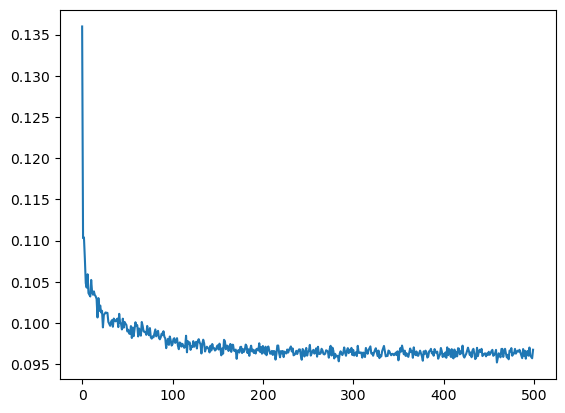

In [19]:
import matplotlib.pyplot as plt
plt.plot(results)
plt.show()